## OVERVIEW
---
* Image Processing
* Transfer Learning With Keras Pretrained Models
* Bottleneck Feature Extraction
* Keras library for building a basic Convolutional Neural Network.
* Predictive Modelling
* Plotting of Model Performance

In [110]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob


from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import np_utils, to_categorical
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### DATA UTILITIES


In [2]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copy the Xception models
!cp ../input/keras-pretrained-models/xception* ~/.keras/models/
#show
!ls ~/.keras/models

xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [3]:
data_folder = '../input/face-mask-detection-data'
categories = ['with_mask', 'without_mask']
len_categories = len(categories)

### CREATE A DATAFRAME

In [4]:
#show number of images per category
for category in categories:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(data_folder, category)))))

with_mask 1915 images
without_mask 1918 images


In [5]:
train_data = []

for i, category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)    
    for path in os.listdir(os.path.join(class_folder)):
        train_data.append(['{}/{}'.format(category, path), category, i])
df = pd.DataFrame(train_data, columns=['filepath', 'class', 'label'])

#reduce the data
SAMPLE_PER_CATEGORY = 500
df = pd.concat([df[df['class'] == i][:SAMPLE_PER_CATEGORY] for i in categories])

print('DATAFRAME SHAPE: ',df.shape)
df.head()

2it [00:00, 157.83it/s]

DATAFRAME SHAPE:  (1000, 3)


,filepath,class,label
0,"with_mask/image1,373.jpg",with_mask,0
1,with_mask/image328.jpg,with_mask,0
2,with_mask/image904.jpg,with_mask,0
3,with_mask/image475.jpg,with_mask,0
4,"with_mask/image1,725.jpg",with_mask,0


### SHOW SAMPLE IMAGES

In [6]:
# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

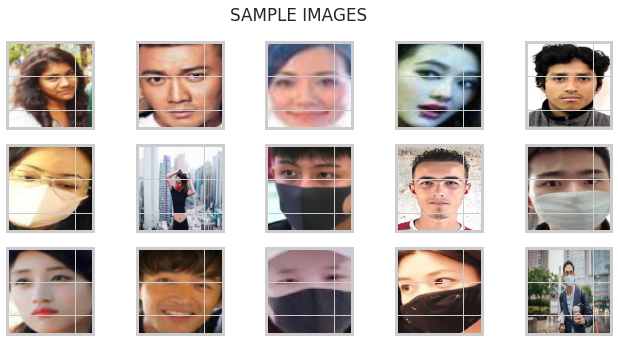

In [7]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['filepath'].iloc[np.random.randint(998)], (255,255)))/255);
plt.show();

### PREPROCESSING THE IMAGES

In [8]:
# function to sharpen the images
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp / 255

In [9]:
INPUT_SIZE = 255
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, 3), dtype='float')

for i, file in tqdm(enumerate(df['filepath'])):
    img_sharpen = sharpen_image(read_img(file, (255,255)))
    X_train[i] = xception.preprocess_input(np.expand_dims(img_sharpen.copy(), axis=0))
    

1000it [00:13, 73.83it/s]


In [10]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (1000, 255, 255, 3)
Train Image Size:  195075000


In [12]:
#split the data
y = df['label']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

### BOTTLENECK FEATURE EXTRACTION

In [13]:
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

7/7 [==============================] - 1s 99ms/step


In [14]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (800, 2048)
Train Size:  1638400
Validation Shape:  (200, 2048)
Validation Size:  409600


### MODELLING

In [103]:
#optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

#keras model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_70 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 65        
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [105]:
#set callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

#fit the data
history = model.fit(bf_train_x, y_train, batch_size=32, epochs=500, callbacks=callbacks)

Epoch 1/500
25/25 [==============================] - 0s 2ms/step - loss: 0.6828 - accuracy: 0.5487
Epoch 2/500
25/25 [==============================] - 0s 2ms/step - loss: 0.6742 - accuracy: 0.5725
Epoch 3/500
25/25 [==============================] - 0s 2ms/step - loss: 0.6393 - accuracy: 0.6488
Epoch 4/500
25/25 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.6150
Epoch 5/500
25/25 [==============================] - 0s 2ms/step - loss: 0.5931 - accuracy: 0.6900
Epoch 6/500
25/25 [==============================] - 0s 2ms/step - loss: 0.5517 - accuracy: 0.7138
Epoch 7/500
25/25 [==============================] - 0s 2ms/step - loss: 0.5323 - accuracy: 0.7513
Epoch 8/500
25/25 [==============================] - 0s 2ms/step - loss: 0.5343 - accuracy: 0.7175
Epoch 9/500
25/25 [==============================] - 0s 2ms/step - loss: 0.5053 - accuracy: 0.7487
Epoch 10/500
25/25 [==============================] - 0s 2ms/step - loss: 0.4885 - accuracy: 0.7563
Epoch 11/

25/25 [==============================] - 0s 2ms/step - loss: 0.1393 - accuracy: 0.9413
Epoch 84/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1309 - accuracy: 0.9475
Epoch 85/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1241 - accuracy: 0.9513
Epoch 86/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1729 - accuracy: 0.9287
Epoch 87/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1472 - accuracy: 0.9337
Epoch 88/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9488
Epoch 89/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1376 - accuracy: 0.9425
Epoch 90/500
25/25 [==============================] - 0s 2ms/step - loss: 0.2029 - accuracy: 0.9200
Epoch 91/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1377 - accuracy: 0.9450
Epoch 92/500
25/25 [==============================] - 0s 3ms/step - loss: 0.1178 - accuracy: 0.9513
Epoch 93/500


25/25 [==============================] - 0s 2ms/step - loss: 0.0935 - accuracy: 0.9600
Epoch 165/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0672 - accuracy: 0.9787
Epoch 166/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.9725
Epoch 167/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1017 - accuracy: 0.9588
Epoch 168/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1910 - accuracy: 0.9312
Epoch 169/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1939 - accuracy: 0.9137
Epoch 170/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0729 - accuracy: 0.9725
Epoch 171/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9700
Epoch 172/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.9450
Epoch 173/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0939 - accuracy: 0.9650
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - accuracy: 0.9837
Epoch 246/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - accuracy: 0.9812
Epoch 247/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - accuracy: 0.9887
Epoch 248/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1558 - accuracy: 0.9550
Epoch 249/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1006 - accuracy: 0.9538
Epoch 250/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1128 - accuracy: 0.9563
Epoch 251/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0648 - accuracy: 0.9762
Epoch 252/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9837
Epoch 253/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1184 - accuracy: 0.9513
Epoch 254/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0764 - accuracy: 0.9712
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.9912
Epoch 327/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - accuracy: 0.9862
Epoch 328/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - accuracy: 0.9650
Epoch 329/500
25/25 [==============================] - 0s 2ms/step - loss: 0.1064 - accuracy: 0.9588
Epoch 330/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9688
Epoch 331/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - accuracy: 0.9875
Epoch 332/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 0.9850
Epoch 333/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9862
Epoch 334/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9887
Epoch 335/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9837
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0252 - accuracy: 0.9937
Epoch 408/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - accuracy: 0.9837
Epoch 409/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9962
Epoch 410/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9887
Epoch 411/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9887
Epoch 412/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.9875
Epoch 413/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - accuracy: 0.9900
Epoch 414/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9950
Epoch 415/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - accuracy: 0.9812
Epoch 416/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0294 - accuracy: 0.9875
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0921 - accuracy: 0.9700
Epoch 489/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.9937
Epoch 490/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9975
Epoch 491/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9962
Epoch 492/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.9912
Epoch 493/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - accuracy: 0.9912
Epoch 494/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.9912
Epoch 495/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9875
Epoch 496/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9825
Epoch 497/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9937
Epoc

### LOSS AND ACCURACY

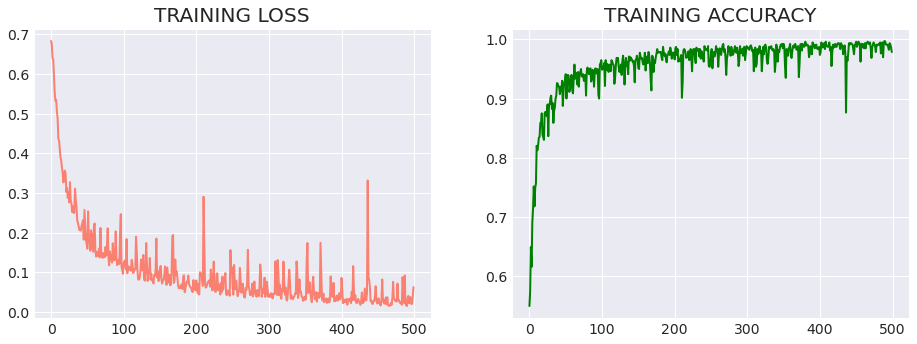

In [111]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [108]:
#predict the validation data
predictions = model.predict_classes(bf_train_val)

### CLASSIFICATION REPORT

In [109]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        99
           1       0.93      0.89      0.91       101

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



### CONFUSION MATRIX

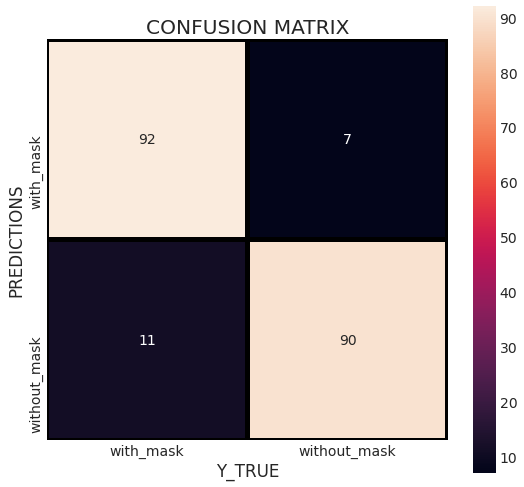

In [118]:
con_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(8,8))
plt.title('CONFUSION MATRIX')

sns.heatmap(con_mat,
            yticklabels=['with_mask', 'without_mask'], 
            xticklabels=['with_mask', 'without_mask'],
            annot=True, linecolor='black', linewidths=4, square=True);

plt.xlabel('Y_TRUE'), plt.ylabel('PREDICTIONS');